#Integrantes

* Andrés Pérez
* John Serrato
* Juana Morales

#Generalidades

Se encuentran en un documento adjunto en el repositorio.

In [1]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install pandas-profiling

import re, string, unicodedata
#import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

In [2]:
# Librería para manejar las contracciones que se presentan en el inglés.
#!pip install contractions

In [3]:
# librería para manejar las flexiones gramaticales en el idioma inglés y espanol
!pip install inflect
!pip install pattern
# Manejo de gráficas
!pip install scikit-plot


  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [4]:
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
from nltk.stem import PorterStemmer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
# ¿Cuales son esas palabras vacías?

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
# ¿Qué es el lema de una palabra? ¿Qué tan dificil puede ser obtenerlo, piensa en el caso en que tuvieras que escribir la función que realiza esta tarea?
nltk.download('omw')

[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

# 1 Carga de Datos

In [7]:
# Configurar Pandas para mostrar todas las columnas y hasta 50 filas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

# Intentar leer el archivo Excel con diferentes motores
file_path = "/content/sample_data/PROYECTO1/ODScat_345 (1).xlsx"

try:
    df_ODS = pd.read_excel(file_path, engine='openpyxl')
except:
    df_ODS = pd.read_excel(file_path, engine='xlrd')  # Usar xlrd si openpyxl falla

# Crear una copia del dataframe
data_t = df_ODS.copy()

# Si hay problemas con tildes, reemplazarlos manualmente
def replace_special_chars(df):
    # Definir un diccionario de reemplazo
    replacements = {
        'Ã¡': 'á', 'Ã©': 'é', 'Ã­': 'í', 'Ã³': 'ó', 'Ãº': 'ú',
        'Ã': 'Á', 'Ã': 'É', 'Ã': 'Í', 'Ã': 'Ó', 'Ã': 'Ú',
        'Ã±': 'ñ', 'Ã': 'Ñ', 'Ã¼': 'ü', 'Ã': 'Ü', 'ã³':'ó', 'ã­':'í',
        'ã©':'é', 'ã¡':'á', 'ãº':'ú', 'ã°':'ó', 'ã':'ñ', 'ã':'ü'
    }
    # Reemplazar caracteres en cada columna de tipo objeto
    for col in df.select_dtypes(include=['object']).columns:
        for old, new in replacements.items():
            df[col] = df[col].str.replace(old, new)
    return df

# Reemplazar caracteres especiales
data_t = replace_special_chars(data_t)

El código anterior tiene la función de leer el archivo Excel que contiene datos relacionados con los ODS y asegurarse de que no haya problemas con caracteres especiales (como tildes) en el texto. De esta forma el tratamiento que se le hicieron a los datos en la carga fue el siguiente:

### **Intentar leer el archivo Excel con diferentes motores:**

Se intenta leer el archivo con el motor openpyxl y, en caso de fallo, se utiliza xlrd como alternativa. Esto es útil para garantizar la compatibilidad con diferentes formatos de archivos Excel, ya que algunos archivos pueden necesitar distintos motores de lectura.

### **Crear una copia del DataFrame:**

Se crea una copia de los datos leídos (data_test) para evitar alterar el DataFrame original (df_ODS_test). Esto asegura que los datos originales permanezcan intactos, lo que es una buena práctica cuando se está manipulando información.

### **Función para reemplazar caracteres especiales:**

La función replace_special_chars(df) tiene como propósito identificar y reemplazar caracteres con tildes u otros signos especiales que puedan estar mal codificados o causar problemas en el procesamiento posterior. Los caracteres que suelen aparecer mal codificados, como "Á", "É", "Í", "Ó", "Ú", etc., se reemplazan manualmente con sus versiones correctas.
Esto es crucial para garantizar que los datos se procesen correctamente, especialmente cuando se aplican técnicas de modelos de clasificación, cuyo éxito de los resultados dependen de un texto limpio y sin errores de codificación.

###**Aplicación del reemplazo de caracteres:**

Se aplica la función de reemplazo a todas las columnas de tipo object (columnas de texto) del DataFrame, para asegurarse de que cualquier cadena de texto sea corregida. Esto evita que los caracteres especiales incorrectos interfieran en el análisis o clasificación de los datos.


Los datos cargados tienen la siguiente estructura

In [8]:
data_t.head(50)

,Textos_espanol,sdg
0,"Por ejemplo, el número de consultas externas d...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3
5,Probar pronto la medicina rural puede crear el...,3
6,La duración media de la estancia en el hospita...,3
7,"El período retrospectivo es de 20 años, de 195...",3
8,Ya se están vinculando algunos datos de los re...,3
9,"En este sentido, es una forma eficaz de mejora...",3


In [9]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  4049 non-null   object
 1   sdg             4049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.4+ KB


# 2 Entendimiento de los Datos

Los tipos de dato en cada una de las columnas son los siguientes. Se puede apreciar que hay una columna que representa una variable en forma de texto (el cuál es el que va a ser procesado) y otra que representa una variable de tipo entero que representa el ODS asociado a la variable en formato texto.

In [10]:
data_t.dtypes

,0
Textos_espanol,object
sdg,int64


Para entender los mensajes, se realizan 'estadísticas descriptivas' para poder obtener un análisis de los textos.

In [11]:
from scipy import stats as st
from collections import Counter

textos = data_t.copy()
textos['Conteo'] = [len(x) for x in textos['Textos_espanol']]
textos['Moda'] = [Counter(x.split(' ')).most_common(1)[0][0] for x in textos['Textos_espanol']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]
textos

,Textos_espanol,sdg,Conteo,Moda,Max,Min
0,"Por ejemplo, el número de consultas externas d...",3,935,de,18,1
1,"En 2007, el gobierno central financió directam...",3,476,del,14,1
2,"Claramente, hay muchos otros factores en juego...",3,1207,de,15,1
3,"Por ejemplo, el estado australiano de Victoria...",3,1090,de,17,1
4,"El consumo anual de alcohol se estima en 15,7 ...",3,895,de,13,1
...,...,...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,822,de,16,1
4045,La participación de las mujeres en roles de li...,5,514,de,16,1
4046,"Según el WEF, según las tendencias de 2016, po...",5,445,el,17,1
4047,"Sirve como recurso y foro para las agencias, c...",5,1013,de,15,1


## 2.1 Exploración de los Datos

In [12]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
from pandas_profiling import ProfileReport

profile = ProfileReport(data_t)
profile

     / 17.8 MB 26.4 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=356222 sha256=fd177fb4be994b376f38351d4e25b5cb0bbd27c04a671f6e516921f99ad3ccc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-l91tgm4a/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e859a949367ba842577b
Successfully built ydata-profiling
  Attempting uninstall: ydata-profiling
    Found existing installation: ydata-profiling 4.10.0
    Uninstalling ydata-profiling-4.10.0:
      Successfully uninstalled ydata-profiling-4.10.0


<ipython-input-12-0233ac1cfead>:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2.2 Verificar la calidad de datos

Luego de hacer el perfilamiento de datos, podemos ver de una forma muy por encima, que no hay problemas de duplicados, valores nulos, validez ni consistencia. Sin embargo, se evaluará detalladamente cada uno de los criterios de calidad.

# 3 Preparación de los datos

## 3.1 Limpieza de los datos

Este proceso de limpieza se dividirá en 4 pasos: Completitud, Duplicidad, Consistencia y Estadarización.

También, para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:

- Limpieza de los datos.


### 3.1.1 Completitud

Para poder realizar este paso primero es necesario saber si hay filas con valores vacíos o nulos para cada columna

In [13]:
(data_t.isna().sum() / data_t.shape[0]).sort_values(ascending = False)

,0
Textos_espanol,0.0
sdg,0.0


Se evidencia que no hay valores nulos en ninguna de las columnas del dataframe, por lo que se puede concluir que no hay problemas de completitud.

### 3.1.2 Duplicidad de los datos

En este momento se busca encontrar campos con valores duplicados. Los registros duplicados se eliminan.

In [14]:
duplicados= data_t.duplicated()
num_duplicados = duplicados.sum()
print('Número de duplicados:', num_duplicados)

Número de duplicados: 0


Se evidencia que no hay filas duplicados en el data frame, por lo que se concluye que no hay problemas de unicidad.

### 3.1.3 Consistencia


In [15]:
data_t["Textos_espanol"].value_counts()


,count
Textos_espanol,
"Por ejemplo, el número de consultas externas de especialistas es de 319 por cada mil derechohabientes en el SP, en comparación con 338 y 620 por cada mil derechohabientes en el IMSS y el ISSSTE, respectivamente. Si bien algunas de estas diferencias pueden reflejar una necesidad desigual (como la población ligeramente mayor del ISSSTE), otras no pueden justificarse de esta manera. El número de recetas que no pudieron ser surtidas en su totalidad por un farmacéutico debido a la falta de existencias es de 33% dentro del SP en comparación con 14% dentro del IMSS según los datos de la encuesta (aunque las propias cifras de los institutos de la SS sugieren tasas más altas de recetas surtidas). Ambas cifras se encuentran entre las más altas de la OCDE. El gasto de bolsillo no se ha reducido significativamente en la última década, a pesar de los esfuerzos para lograr la cobertura sanitaria universal a través de la reforma del SP.",1
"Sin embargo, las pequeñas empresas representan menos del 2% de las carteras de préstamos de los bancos, en comparación con un promedio de 12% a 15% en algunos países más desarrollados. El gobierno, las organizaciones de mujeres empresarias y los bancos están trabajando juntos para crear un entorno que fomente el desarrollo de empresas dirigidas por mujeres. El Banco Nacional de Abu Dhabi juega un papel de liderazgo en este esfuerzo.",1
"El recuadro 5.6 resume la experiencia positiva de Sudáfrica al establecer cuotas y convertirse en el paÃs africano lÃder en la presencia de mujeres en los consejos de administración de las empresas. La experiencia de Sudáfrica ofrece una valiosa lección sobre los beneficios de extender la acción afirmativa más allá del proceso electoral. Puede ser extremadamente difÃcil y polÃticamente delicado enmendar una constitución para incluir una disposición sobre cuotas, pero está demostrado que sus efectos desencadenan aumentos espectaculares en la participación de las mujeres en las organizaciones a las que van dirigidas (Fridell, 2009). La representación de la mujer en los gobiernos locales ha demostrado marcar la diferencia.",1
"Asimismo, es necesario difundir más ampliamente la información sobre la situación de las mujeres en comparación con la de los hombres en sus países en lo que respecta al acceso, uso e impacto de las TIC, con el fin de trabajar por una sociedad de la información equitativa a escala mundial. Estas encuestas ayudan a recopilar datos que muestran las diferencias entre hombres y mujeres, lo que permite comprender mejor los roles de género, las responsabilidades y las diferencias en el control de los recursos en un contexto determinado. Datos sobre acceso y uso de la tierra.",1
"Aparte de este dato, las mujeres clasifican sus contribuciones principalmente entre las de tipo blando y no material, como las tareas domésticas y el cuidado de los hijos. El grupo más numeroso de hombres de entre 25 y 64 años menciona ""el trabajo, los ingresos y el pago de facturas"", al igual que sus homólogas femeninas. Aunque se suponía que los distintos grupos de edad de las mujeres clasificarían ""mostrar amor y afecto"" significativamente más alto que los hombres, puede sorprender que también los hombres (de todos los grupos de edad) perciban ""mostrar amor y afecto"" como una contribución importante al hogar.",1
...,...
"Las reformas varían de un país a otro, ya que están influenciadas por el contexto, las tradiciones, los marcos institucionales y los desafíos nacionales y regionales específicos. Todas estas políticas apuntan a mejorar la calidad de las escuelas y la instrucción y se han agrupado según las diferentes opciones de política y su alcance. La mayoría de los jóvenes de 15 años en los países de la OCDE encuentran que sus aulas son propicias para el aprendizaje, pero existen desafíos en las escuelas de algunos países, incluida la falta de motivación de los estudiantes, la falta de un plan de estudios relevante, las dificultades para atraer y r

In [16]:
data_t["Textos_espanol"].dtype

dtype('O')

In [17]:
data_t["sdg"].value_counts()

,count
sdg,
5,1451
4,1354
3,1244


In [18]:
data_t["sdg"].dtype

dtype('int64')

Se evidencia que ambas columnas tienen el tipo de dato que corresponde a cada una (texto y numérico). Con esto se concluye que no hay problemas de consistencia.

### 3.1.4 Validez

Se hace una verificación de que, para el caso de la columna categórica sdg que corresponde al ODS, tenga valores de 3, 4 o 5.

In [19]:
data_t["sdg"].value_counts()

,count
sdg,
5,1451
4,1354
3,1244


Se evidencia que la columna sdg no tiene valores diferentes a los esperados y establecidos para esta variable categórica.

### 3.1.5 Limpieza de datos (pre-procesamiento de los datos)

Este paso se hace para dejar los "Textos_espanol" en texto plano. También para eliminar caracteres especiales y pasar todo a minúscula.


In [20]:
from nltk.stem import PorterStemmer

In [21]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
wpt = nltk.WordPunctTokenizer()
ps = PorterStemmer()

In [23]:
def normalize_documents(doc):
    """Normalize document by preserving accented words and capitalized proper names"""

    # Mantener tildes y letras con acentos, ñ, etc.
    # Elimina cualquier carácter no alfabético, excepto los acentos
    doc = re.sub(r'[^\w\sáéíóúÁÉÍÓÚñÑ]', '', doc)

    # Dividir el documento en palabras para manejar nombres propios
    words = doc.split()

    new_words = []
    capitalize_next = True  # Bandera para saber si debemos capitalizar (inicio de oración)

    for word in words:
        # Revisar si la palabra es el inicio de una oración o tiene que respetarse por ser nombre propio
        if capitalize_next:
            new_word = word  # Mantiene la palabra tal como está (manteniendo nombres propios)
            capitalize_next = False  # Ya no es el inicio de una oración
        else:
            # Comprobar si es un nombre propio: primera letra mayúscula y el resto minúsculas
            if word[0].isupper() and word[1:].islower():
                new_word = word  # Mantiene el nombre propio sin cambios
            else:
                new_word = word.lower()  # Convierte el resto a minúsculas

        # Verificar si la palabra termina con un punto (fin de oración)
        if word.endswith('.'):
            capitalize_next = True

        new_words.append(new_word)

    # Recombinar el texto después de procesar los nombres propios
    doc = ' '.join(new_words)

    # Tokenización y eliminación de stopwords
    tokens = wpt.tokenize(doc)

    # Aplicar stemming, omitiendo las stop words
    filtered_token = [ps.stem(token) for token in tokens if token.lower() not in stop_words]

    # Recombinar las palabras tokenizadas
    doc = ' '.join(filtered_token)

    return doc

In [24]:
normalize_corpus = np.vectorize(normalize_documents)

In [25]:
norm_textos_espanol = normalize_corpus(data_t["Textos_espanol"])

In [26]:
norm_textos_espanol

array(['ejemplo número consulta externa especialista 319 cada mil derechohabient sp comparación 338 620 cada mil derechohabient imss issst respectivament si bien diferencia pueden reflejar necesidad desigu población ligerament mayor issst pueden justificars manera número receta pudieron ser surtida totalidad farmacéutico debido falta existencia 33 dentro sp comparación 14 dentro imss según dato encuesta aunqu propia cifra instituto ss sugieren tasa alta receta surtida amba cifra encuentran alta ocd gasto bolsillo reducido significativament última década pesar esfuerzo lograr cobertura sanitaria univers travé reforma sp',
       '2007 gobierno central financió directament solo 03 gasto total salud realizó transferencia específica gasto salud ascendieron 56 gasto total mayor part gasto presupuestario salud realizan gobierno condado condado pobr solo pueden ofrec bajo nivel atención población local gobierno provinci proporciona subsidio lado oferta hospital',
       'clarament factor jueg

In [27]:
data_SVM = data_t.copy()

In [28]:
data_t["Textos_espanol"] = norm_textos_espanol

### 3.1.6 Datos procesados (Excel)

A continuación se guardan en un archivo Excel los datos procesados y con todos los ajustes realizados a partir del análisis de calidad (Validez, Consistencia, Unicidad y Completitud). Estos datos fueron utilizados para el entrenamiento de los algoritmos NAIVE BAYES MULTINOMIAL y XGBOOST. Sin embargo, para el caso del algoritmo SVM estos datos procesados no fueron utilizados ya que con ellos se obtuvieron resultados levemente inferiores (Accuracy= 98,27%) a los obtenidos con los datos copia de los originales "data_SVM" (Accuracy=98,35%). Aún así, cabe aclarar, que estos datos cumplen con todos los requisitos de calidad, tal y como se ve puede detallar en el análisis y tratamiento que se le hizo anteriormente a "data_t".

In [28]:
# Guardar el archivo con datos procesados y con ajustes según análisis de calidad
output_file_proce_path = '/content/sample_data/PROYECTO1/datos_procesados.xlsx'  # Reemplaza con la ruta de salida
data_t.to_excel(output_file_proce_path, index=False)

print(f"Archivo guardado en: {output_file_proce_path}")

Archivo guardado en: /content/sample_data/PROYECTO1/datos_procesados.xlsx


# 4 Implementacion Algoritmos de Aprendizaje Automático y selección del mejor Algoritmo


## 4.1 Naive Bayes Multinomial

### **Implementado por:** JUANA MARÍA MORALES RAMOS (202021591)

El algoritmo Naive Bayes es un clasificador probabilístico basado en el teorema de Bayes. Este se utiliza comúnmente en problemas de clasificación de texto debido a su simplicidad y efectividad, especialmente cuando se trata de datos con muchas características (como las palabras en los textos).

En este contexto, se utilizará una variante llamada **Naive Bayes Multinomial**, que es especialmente útil cuando los datos de entrada son conteos de frecuencia o ponderaciones como las producidas por TF-IDF. Este modelo calcula las probabilidades basadas en la frecuencia de las palabras en cada clase. El clasificador multinomial cuenta cuántas veces aparece cada palabra en los textos de una clase específica y calcula la probabilidad de que un nuevo texto pertenezca a esa clase basándose en estas frecuencias.

Decidimos implementarlo, dado que, según la respectiva investigación realizada del algortimo, se evidenció que funciona bien con conjuntos de datos grandes como los que suelen encontrarse en problemas de clasificación de texto.
Debido a su simplicidad, el tiempo de entrenamiento es rápido y es muy eficiente en términos de uso de memoria. Adicional a ello, Naive Bayes proporciona una interpretación clara y comprensible de cómo se clasifican los textos. Calcula la probabilidad de pertenencia a una clase en función de las palabras que contiene el texto, lo que facilita entender por qué un texto fue clasificado de cierta manera.



###4.1.1 Crear una copia del dataframe para el procesamiento

Primero, vamos a asegurarnos de crear una copia del DataFrame antes de comenzar con cualquier preprocesamiento o modelado.

In [ ]:
# Crear una copia del DataFrame original para no modificarlo
df_naive_bayes = data_t.copy()

###4.1.2 Vectorización de los datos utilizando la copia

Antes de aplicar el algoritmo de Naive Bayes, los datos textuales necesitan ser convertidos en una representación numérica que el modelo pueda procesar. Para ello usamos TF-IDF (Term Frequency-Inverse Document Frequency), que no solo cuenta las palabras, sino que les asigna pesos en función de su importancia relativa.

In [ ]:
# Inicializar el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Ajustar y transformar el texto preprocesado (en la copia) a la matriz de TF-IDF
X = tfidf_vectorizer.fit_transform(norm_textos_espanol).toarray()

# Definir la variable objetivo (etiquetas de clase) en la copia
y = df_naive_bayes['sdg']

###4.1.3 División del conjunto de datos en entrenamiento y prueba utilizando la copia

El conjunto de datos debe dividirse en dos partes:

* Entrenamiento: Para entrenar el modelo.
* Prueba: Para evaluar el rendimiento del modelo en datos que no ha visto durante el entrenamiento.


In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###4.1.4 Entrenamiento del modelo Naive Bayes Multinomial

Entrenar el modelo con los datos de entrenamiento generados a partir de la copia.

In [ ]:
# Inicializar el modelo Naive Bayes Multinomial
nb_model = MultinomialNB()

# Entrenar el modelo con los datos de entrenamiento
nb_model.fit(X_train, y_train)


MultinomialNB()

###4.1.5 Evaluación del Modelo

Ahora que el modelo está entrenado, podemos evaluarlo utilizando los datos de prueba, que el modelo no ha visto antes. Esto nos dará una idea de qué tan bien funciona el modelo en la clasificación de textos.

La evaluación del modelo implica medir su rendimiento utilizando un conjunto de métricas estándar. Dado que estamos trabajando con un problema de clasificación, las métricas comunes incluyen:

* Accuracy
* Precision
* Recall
* F1-score
* Matriz de Confusión



In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = nb_model.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

''' # Reporte de clasificación: precision, recall, F1-score
print('Classification Report:')
print(classification_report(y_test, y_pred, output_dict=True)
)
 '''

# Obtener el reporte de clasificación como un diccionario
report = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en un DataFrame para mejorar la legibilidad
df_classification_report = pd.DataFrame(report).transpose()

# Mostrar el reporte de clasificación como DataFrame
print("Reporte de clasificación:")
print(df_classification_report)

#ACAAA

# Matriz de Confusión
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Realizar predicciones en el conjunto de prueba
y_pred = nb_model.predict(X_test)



Accuracy: 0.9765432098765432
Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.97      0.99       250
           4       0.96      0.98      0.97       268
           5       0.97      0.98      0.97       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810

Confusion Matrix:
[[243   3   4]
 [  0 263   5]
 [  0   7 285]]


###4.1.6 Visualización de la Matriz de Confusión

Esto se realizó para que sirviera de ayuda a entender mejor cómo el modelo clasifica los textos en las diferentes categorías.

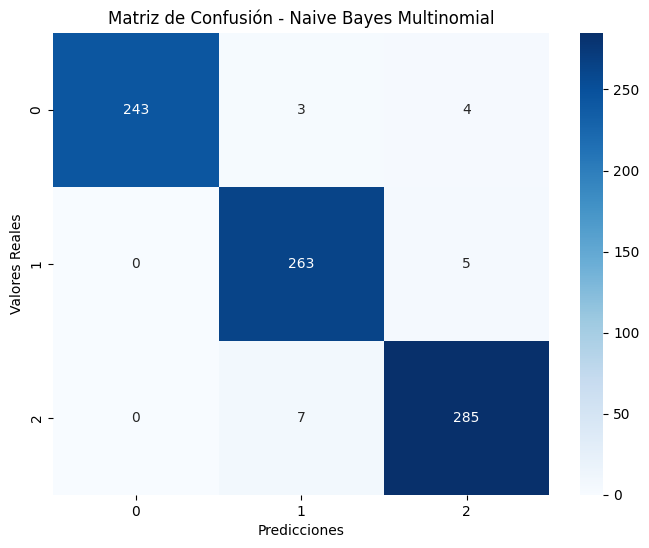

In [ ]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Naive Bayes Multinomial')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Esta matriz de confusión muestra el rendimiento del modelo, donde se tienen tres clases etiquetadas como 0, 1, y 2. A partir de la matriz, podemos hacer las siguientes observaciones:

**1. Clase 0 (Fila 1)**
  * 243 ejemplos de la clase 0 fueron correctamente clasificados como 0.
  * 3 ejemplos de la clase 0 fueron incorrectamente clasificados como clase 1.
  * 4 ejemplos de la clase 0 fueron incorrectamente clasificados como clase 2.

  En general, el modelo tiene un buen desempeño en la clase 0, con solo unos pocos errores (3 clasificados como clase 1 y 4 como clase 2).

**2. Clase 1 (Fila 2)**
  * 263 ejemplos de la clase 1 fueron correctamente clasificados como 1.
  * 5 ejemplos de la clase 1 fueron incorrectamente clasificados como clase 2.
  
  El modelo funciona muy bien para la clase 1, aunque tiene una pequeña tendencia a confundir algunos ejemplos de la clase 1 como clase 2 (5 errores).

**3. Clase 2 (Fila 3)**
  * 285 ejemplos de la clase 2 fueron correctamente clasificados como 2.
  * 7 ejemplos de la clase 2 fueron incorrectamente clasificados como clase 1.
  
  El modelo tiene un buen rendimiento para la clase 2, aunque comete algunos errores al clasificar algunos ejemplos de la clase 2 como clase 1.

En general, el modelo tiene un buen rendimiento, ya que la mayoría de los ejemplos caen en la diagonal principal de la matriz de confusión (que representa las clasificaciones correctas). Sin embargo, hay algunos errores de clasificación en las clases 1 y 2, con una ligera confusión entre estas clases.



###4.1.7 Validación Cruzada (Cross-Validation)

La validación cruzada divide el conjunto de datos en varios subconjuntos y entrena el modelo varias veces, cada vez utilizando un subconjunto diferente como conjunto de prueba. Esto proporciona una mejor estimación del rendimiento del modelo.

In [ ]:
# Ejecutar validación cruzada con 5 folds
cv_scores = cross_val_score(nb_model, X, y, cv=5, scoring='accuracy')

# Mostrar los resultados de la validación cruzada
print('Cross-Validation Scores:', cv_scores)
print('Mean Cross-Validation Score:', np.mean(cv_scores))


Cross-Validation Scores: [0.97530864 0.96666667 0.9654321  0.96296296 0.97775031]
Mean Cross-Validation Score: 0.9696241358787713


In [ ]:
''' # Calcular el F1-score
f1 = f1_score(y_test, y_pred, average='weighted')  # Usa 'weighted' para tener en cuenta el desbalance de clases
print(f'F1-Score del modelo (ponderado): {f1}') '''

" # Calcular el F1-score\nf1 = f1_score(y_test, y_pred, average='weighted')  # Usa 'weighted' para tener en cuenta el desbalance de clases\nprint(f'F1-Score del modelo (ponderado): {f1}') "

###4.1.7 Conclusión

* Para la evaluación: Utilizamos la precisión global (accuracy) para obtener una visión general. La matriz de confusión y el informe de clasificación proporcionan una evaluación más detallada, mostrando dónde el modelo clasifica correctamente y dónde comete errores.
La visualización de la matriz de confusión puede ayudarte a ver patrones de error más claramente.

* Para la validación: La validación cruzada es una técnica clave para asegurarse de que el modelo no está sobreajustado y que generaliza bien a diferentes subconjuntos de datos.
Si se llega a tener acceso a datos nuevos, probar el modelo en esos datos es esencial para obtener una visión más clara del rendimiento real del modelo en situaciones del mundo real.

## 4.2 Modelado con XGBoost

### **Implementado por:** JOHN JAIRO SERRATO SUÁREZ (202113080)


XGBoost es un algoritmo basado en árboles de decisión que optimiza el rendimiento combinando múltiples modelos simples para mejorar la precisión. Es ideal para este conjunto de datos porque maneja eficientemente vectores de texto (como los de TF-IDF), trabaja bien con clasificación multi-clase y ofrece alta precisión con tiempos de entrenamiento optimizados.

### 4.2.1 Crear copia del dataframe para el procesamiento

In [ ]:
data_xg = data_t.copy()

### 4.2.2 Vectorización de los datos

In [ ]:
# Vectorización del Texto con TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Ajustar y transformar el texto preprocesado ('Textos_espanol') a la matriz de TF-IDF
X = tfidf_vectorizer.fit_transform(data_xg['Textos_espanol']).toarray()

# Definir la variable objetivo (etiquetas de clase, 'sdg')
y = data_xg['sdg']

In [ ]:
y_reescalado = y - 3

### 4.2.3 División del conjunto de los datos en entrenamiento y prueba

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_reescalado, test_size=0.2, random_state=42)


### 4.2.4 Entrenamiento del modelo

In [ ]:
# Inicializar el modelo XGBoost
xgb_model = XGBClassifier()

In [ ]:
# Entrenar el modelo con los datos de entrenamiento
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Predecir en el conjunto de prueba
y_pred = xgb_model.predict(X_test)

### 4.2.5 Evaluacion del entrenamiento usando XGBoost

In [ ]:
# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 95.31%


In [ ]:
# Mostrar el reporte de clasificación para obtener más detalles sobre el rendimiento del modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       250
           1       0.97      0.93      0.95       268
           2       0.95      0.98      0.96       292

    accuracy                           0.95       810
   macro avg       0.95      0.95      0.95       810
weighted avg       0.95      0.95      0.95       810



El modelo XGBoost tiene un muy buen rendimiento con una precisión global del 95.31%. Los valores de precisión, recall y f1-score están equilibrados entre las clases, lo que indica un buen desempeño sin sesgos. Además, las clases están bien representadas y el modelo es consistente.

### 4.2.6 Visualización de la matriz de Confusión

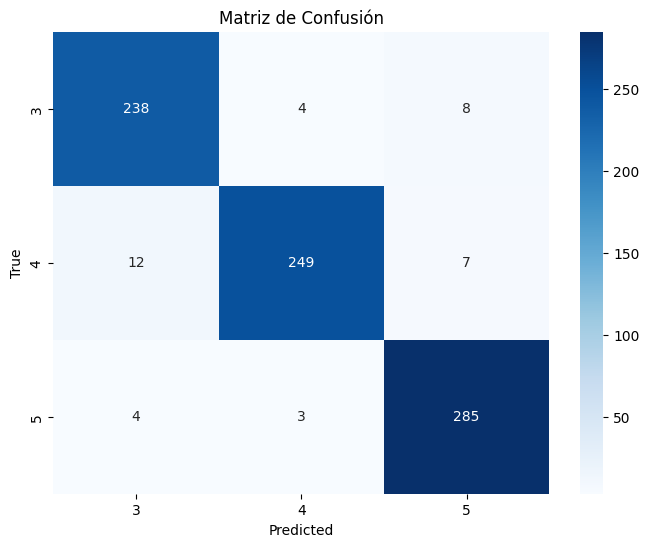

In [ ]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando un heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[3, 4, 5], yticklabels=[3, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

* Clase 3: De las 250 instancias reales de esta clase, 238 fueron correctamente clasificadas, mientras que 4 fueron clasificadas como clase 4 y 8 como clase 5. Esto muestra una ligera confusión con las otras clases, pero la gran mayoría fue clasificada correctamente.

* Clase 4: De las 268 instancias reales, 249 fueron bien clasificadas. Hubo 12 instancias clasificadas erróneamente como clase 3 y 7 como clase 5. Aunque hay algunas confusiones, el desempeño en esta clase sigue siendo fuerte.

* Clase 5: Es la mejor clasificada, con 285 instancias correctas de un total de 292. Solo 4 instancias fueron mal clasificadas como clase 3 y 3 como clase 4, lo que demuestra un alto nivel de precisión.

### 4.2.7 Validación cruzada XGBoost

In [ ]:
# Ejecutar validación cruzada con 5 folds
cv_scores = cross_val_score(nb_model, X, y, cv=5, scoring='accuracy')

# Mostrar los resultados de la validación cruzada
print('Cross-Validation Scores:', cv_scores)
print('Mean Cross-Validation Score:', np.mean(cv_scores))


Cross-Validation Scores: [0.97407407 0.9654321  0.9654321  0.96666667 0.97033375]
Mean Cross-Validation Score: 0.9683877367272504


* Los resultados de la validación cruzada oscilan entre 0.965 y 0.970, lo que indica una consistencia alta en el rendimiento del modelo en distintos subconjuntos de datos.
* El promedio de precisión es 0.968, lo que sugiere que el modelo tiene una capacidad de generalización sólida y no depende excesivamente de un subconjunto específico de datos para alcanzar un buen rendimiento.

Esto es útil para evaluar que el modelo no está sobreajustado a los datos de entrenamiento, ya que el rendimiento es similar en todas las particiones. Además, el alto valor promedio demuestra que el modelo debería funcionar bien en datos no vistos.

## **4.3 SVM (Support Vector Machine)** -- **ALGORITMO SELECCIONADO**

### **Implementado por:** ANDRÉS FELIPE PÉREZ MARTÍNEZ (202215659)

### **¿Qué es?**

**SVM (Support Vector Machine)** es un algoritmo de clasificación que busca encontrar un hiperplano que mejor separe los datos en clases. Cuando los datos no son linealmente separables (es decir, no se pueden dividir mediante una línea o un plano en su forma original), los kernels permiten transformar los datos a un espacio de mayor dimensión donde la separación sea posible.

El **kernel RBF (Radial Basis Function)**, también conocido como **kernel gaussiano**, es una de las opciones más populares de kernel para **SVM**. Funciona bien en problemas en los que la frontera entre las clases no es lineal, lo que significa que los datos no se pueden separar fácilmente con un hiperplano en el espacio original.

### **¿Cómo funciona SVM con RBF?**

1. **Transformación no lineal**:
   - El kernel **RBF** transforma los datos de un espacio de características original (donde no son separables) a un espacio de mayor dimensión donde se pueden separar más fácilmente mediante un hiperplano. Este proceso se realiza de forma implícita, sin tener que calcular las coordenadas en la nueva dimensión.

2. **Maximización del margen**:
   - Una vez que los datos han sido transformados, **SVM** encuentra el **hiperplano óptimo** que maximiza el margen entre las clases. Este margen es la distancia más amplia posible entre los puntos de cada clase y el hiperplano separador.
   - Los puntos que están más cerca del hiperplano se llaman **vectores de soporte**, ya que son los datos que definen la posición del hiperplano.

3. **Parámetros clave**:
   - **`C`**: Controla la regularización del modelo. Un valor alto de **C** minimiza los errores de clasificación en los datos de entrenamiento, mientras que un valor bajo maximiza el margen de separación.
   - **`gamma`**: Controla el alcance de la influencia de un solo punto de datos. Valores altos de **gamma** permiten que cada punto tenga una influencia más localizada, mientras que valores bajos permiten que los puntos distantes influyan más en la clasificación.

4. **Frente no lineal**:
   - A diferencia de los SVM lineales, el SVM con **kernel RBF** puede manejar datos en los que las clases están separadas por fronteras curvas o más complejas, ya que la transformación a un espacio de mayor dimensión permite la creación de frentes no lineales.

### **Ventajas de SVM (RBF) para el caso de ODS**

En el contexto del problema de ODS, donde el objetivo es clasificar opiniones de ciudadanos en relación con los **Objetivos de Desarrollo Sostenible (ODS)**, un SVM con **kernel RBF** puede ser muy útil. Así, se observó que algunas ventajas de usar este modelo para el caso de los **ODS** son:

1. **Capacidad para manejar fronteras no lineales**:
   - Las opiniones de los ciudadanos sobre los ODS pueden ser ambiguas y no seguir patrones lineales fáciles de identificar. La relación entre las palabras utilizadas en las opiniones y los ODS puede ser muy compleja.
   - El kernel **RBF** es ideal para estos casos porque puede encontrar fronteras no lineales, separando las diferentes categorías (por ejemplo, ODS 3, 4, y 5) de manera más precisa.

2. **Alta capacidad de generalización**:
   - SVM con **RBF** tiene una buena capacidad de generalización, lo que significa que puede aprender patrones en los datos de entrenamiento y aplicarlos correctamente a datos nuevos o no vistos.
   - Esto es importante en el caso de los **ODS**, donde las nuevas opiniones de ciudadanos deben ser clasificadas con precisión, incluso si las palabras o expresiones exactas no se han visto antes.

3. **Control sobre el ajuste del modelo**:
   - A través de los parámetros **C** y **gamma**, puedes ajustar el modelo para evitar **sobreajuste** (overfitting). Por ejemplo:
     - Un valor bajo de **C** da más flexibilidad al modelo, permitiéndole maximizar el margen y evitar ajustarse demasiado a los datos de entrenamiento.
     - Un valor adecuado de **gamma** permitirá que el modelo identifique correctamente las relaciones entre las palabras clave y los ODS sin enfocarse en ruido o detalles innecesarios.

4. **Versatilidad en problemas multiclase**:
   - Aunque SVM fue originalmente diseñado para problemas de clasificación binaria, el algoritmo se puede adaptar para manejar problemas multiclase como el de los **ODS** (ODS 3, 4 y 5), utilizando estrategias como "uno contra el resto" (**one-vs-rest**).
   - Esto permite que el SVM con **RBF** se use eficientemente para clasificar opiniones entre múltiples categorías de ODS.

5. **Tolerancia al ruido**:
   - En problemas con datos ruidosos o mal etiquetados (por ejemplo, opiniones ambiguas o contradictorias sobre los ODS), el **SVM con kernel RBF** puede ser más robusto, ya que el parámetro **C** permite controlar qué tan estricto es el modelo con los datos mal clasificados.


### 4.3.1 Cargar librerías

In [29]:
pip install scikit-learn

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score,confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

### 4.3.2 Preparación de los datos

In [31]:
data= data_SVM.copy()
# Dividir los datos en entrenamiento y prueba
X = data['Textos_espanol']  # Columna con los textos
y = data['sdg']  # Columna con las etiquetas (ODS 3, 4, 5)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 4.3.3 Definir el pipeline para SVM

Aquí vamos a usar un pipeline que combina el vectorizador TF-IDF y el modelo SVM.

In [32]:
# Crear el pipeline: Vectorización con TF-IDF y el clasificador SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Vectorización con un límite en el número de características
   # ('svm', SVC(kernel="rbf", gamma='scale', C=1))  # Hiperparámetros obtenidos en la búsqueda anterior
    ('svm', SVC())
    ])

### 4.3.4 Definir los hiperparámetros

In [33]:
# Definir los hiperparámetros a optimizar
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  # Valores para C (regularización)
    'svm__kernel': ['linear', 'rbf'],  # Prueba con kernel lineal y radial
    'svm__gamma': ['scale', 'auto']  # Solo se usa en kernels no lineales
}

### 4.3.5 Configurar la validación cruzada con K-Fold

K-Fold Cross Validation es una técnica que evalúa el rendimiento de un modelo de aprendizaje automático de forma robusta al dividir los datos en K partes iguales, utilizando iterativamente K-1 partes para el entrenamiento y la parte restante para validación. Este proceso se repite K veces, y los resultados se promedian para obtener una evaluación más precisa y confiable. Entre sus beneficios, está el mejor uso de los datos, la mitigación de la dependencia en una sola partición, una mayor capacidad de generalización, y una mejora en la selección de hiperparámetros al evaluarlos más exhaustivamente.

-	**n_splits=10**: Esto divide los datos en 10 folds. El uso de K-Fold Cross Validation con estos n_splits en el caso del modelo SVM para los ODS asegura un buen equilibrio entre el entrenamiento y la validación, maximizando el uso de los datos disponibles. Con 10 pliegues, se reduce el riesgo de sobreajuste y se obtiene una evaluación más robusta y confiable del rendimiento del modelo, especialmente en un problema multiclase como el de los ODS 3, 4 y 5. Esto garantiza que el modelo generalice correctamente en diferentes subconjuntos de los datos, permitiendo tomar decisiones mejor fundamentadas sobre temas críticos como salud, educación y género.

-	**shuffle=True:** Baraja los datos antes de dividirlos en folds.

- **random_state=42:** Fija una base para que los resultados sean reproducibles

Vamos a usar K-Fold Cross Validation para evaluar el rendimiento del modelo.

In [34]:
# Definir el número de folds para la validación cruzada
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Calcular las métricas con validación cruzada (F1-score ponderado)
scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='f1_weighted')

# Mostrar los resultados de la validación cruzada
print(f"F1-Score promedio con K-Fold Cross Validation: {scores.mean():.4f}")
print(f"F1-Score en cada fold: {scores}")

F1-Score promedio con K-Fold Cross Validation: 0.9788
F1-Score en cada fold: [0.97193803 0.97882446 0.97893908 0.97889395 0.98240041 0.97526885
 0.98939005 0.9858644  0.96459131 0.9822729 ]


### 4.3.5.1 Análisis de resultados de la validación cruzada con K-Fold

- **Rendimiento global:** El F1-Score promedio de 0.9788 indica que el modelo SVM está clasificando las opiniones relacionadas con los ODS de manera muy precisa, con un buen balance entre precisión y recall.

- **Consistencia entre folds:** Los puntajes individuales de cada fold están muy cerca unos de otros (entre 0.9645 y 0.9893), lo que significa que el modelo es estable y no depende de una partición específica de los datos para rendir bien.

- **Rendimiento:** El hecho de que varios folds superen el 0.98 en el F1-Score sugiere que el modelo no solo es bueno, sino que maneja muy bien las variaciones en los datos.




### 4.3.6 Configurar GridSearchCV con validación cruzada y realizar busqueda en el conjunto de entrenamiento.

Configurar **GridSearchCV** con validación cruzada permite realizar una búsqueda exhaustiva de los mejores hiperparámetros para un modelo en el conjunto de entrenamiento, evaluando cada combinación de parámetros mediante K-Fold Cross Validation. Durante esta búsqueda, el modelo se entrena con diferentes particiones de los datos y se valida en las particiones restantes, optimizando la métrica objetivo (como el **F1-score**) en cada iteración. Al finalizar, **GridSearchCV** selecciona la combinación de hiperparámetros que ofrece el mejor rendimiento promedio, garantizando una mayor generalización del modelo.

In [35]:
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_weighted', cv=kfold)

In [36]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000)),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'rbf']},
             scoring='f1_weighted')

### 4.3.7 Obtener los mejores hiperparámetros

In [37]:
# Ver los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

Mejores hiperparámetros: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


### **4.3.7.1 Interpretación general de los mejores hiperparámetros:**

- **C=1:** El modelo SVM encuentra un balance adecuado entre permitir algunos errores de clasificación y maximizar el margen de separación entre las clases. Esto ayuda a evitar el sobreajuste a los datos de entrenamiento y mejora la capacidad del modelo para generalizar en nuevos datos.

- **gamma='scale':** Este valor ajusta automáticamente la influencia de cada ejemplo de entrenamiento en función del número de características, lo que permite que el modelo sea flexible, pero sin caer en el sobreajuste.

- **kernel='rbf':** El uso del kernel RBF permite que el modelo encuentre fronteras de decisión no lineales entre las clases de ODS, lo que es útil cuando las relaciones entre las palabras en las opiniones y los ODS no son fácilmente lineales.

### 4.3.8  Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba

In [38]:
#y_pred = pipeline.predict(X_test)
y_pred= grid_search.best_estimator_.predict(X_test)

#Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.98      0.98      0.98       372
           4       0.98      0.98      0.98       402
           5       0.98      0.99      0.99       441

    accuracy                           0.98      1215
   macro avg       0.98      0.98      0.98      1215
weighted avg       0.98      0.98      0.98      1215



### 4.3.9 Presentación de resultados del Modelo (Métricas de calidad y Matriz de confusión)

### 4.3.9.1 Resultados métricas de calidad

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [40]:
# Obtener el reporte de clasificación como un diccionario
report = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en un DataFrame para mejorar la legibilidad
df_classification_report = pd.DataFrame(report).transpose()

# Mostrar el reporte de clasificación como DataFrame
print("Reporte de clasificación:")
print(df_classification_report)

Reporte de clasificación:
              precision    recall  f1-score      support
3              0.983871  0.983871  0.983871   372.000000
4              0.984962  0.977612  0.981273   402.000000
5              0.981982  0.988662  0.985311   441.000000
accuracy       0.983539  0.983539  0.983539     0.983539
macro avg      0.983605  0.983382  0.983485  1215.000000
weighted avg   0.983546  0.983539  0.983534  1215.000000


Podemos generar diferentes métricas macro de rendimiento como la exactitud, el recall, la precisión y la puntuación F1.

In [41]:
# Exactitud (Accuracy)
print('Exactitud: %.8f' % accuracy_score(y_test, y_pred))

# Recall, Precisión y F1-Score
print("Recall (macro): {}".format(recall_score(y_test, y_pred, average='macro')))
print("Precisión (macro): {}".format(precision_score(y_test, y_pred, average='macro')))
print("Puntuación F1 (macro): {}".format(f1_score(y_test, y_pred, average='macro')))

Exactitud: 0.98353909
Recall (macro): 0.9833816798532391
Precisión (macro): 0.9836051185796517
Puntuación F1 (macro): 0.9834850368149709


### 4.3.9.1**.1** Interpretación y análisis de las métricas de calidad obtenidas


### **Interpretación de cada métrica:**

1. **Exactitud (Accuracy)**:
   - **98.35%** de las predicciones realizadas por el modelo son correctas. La exactitud refleja qué tan bien el modelo está clasificando las observaciones en general, independientemente de las clases. Esta métrica muestra que el modelo tiene un desempeño global muy alto, dado que más del 98% de las predicciones corresponden a la etiqueta correcta.

2. **Recall (macro)**:
   - **98.34%** es el promedio del **recall** entre todas las clases. El **recall** mide la capacidad del modelo para identificar correctamente las instancias de una clase en particular (es decir, cuántos verdaderos positivos se identifican correctamente sobre el total de elementos que realmente pertenecen a esa clase). Dado que es un promedio **macro**, se calcula el **recall** por cada clase y luego se promedia. Este valor alto indica que el modelo logra capturar correctamente la mayoría de las instancias de cada clase de los ODS.

3. **Precisión (macro)**:
   - **98.36%** es el promedio de la **precisión** en todas las clases. La **precisión** mide la capacidad del modelo para evitar falsos positivos (es decir, cuántas de las predicciones positivas son realmente correctas). Al ser **macro**, se calcula la precisión de cada clase por separado y se promedia. Este alto valor muestra que el modelo rara vez clasifica incorrectamente una observación como parte de una clase cuando no lo es.

4. **Puntuación F1 (macro)**:
   - **98.35%** es el promedio de la **F1-Score** en todas las clases. La **puntuación F1** es la métrica que armoniza la precisión y el recall, proporcionando una sola medida de desempeño considerando ambos aspectos. Al ser **macro**, se calcula la F1 por cada clase y luego se promedia. Dado que el valor es tan cercano al 100%, esto indica que el modelo mantiene un equilibrio excelente entre la capacidad para detectar correctamente las clases y evitar falsos positivos en las predicciones.

### Análisis general:

- **Alto rendimiento del modelo**: Todas las métricas muestran que el modelo tiene un excelente desempeño. Con valores superiores al 98% en exactitud, recall, precisión y F1, el modelo está prediciendo correctamente la gran mayoría de las instancias con muy pocos errores.
  
- **Equilibrio entre precisión y recall**: Tanto la precisión como el recall tienen valores muy cercanos, lo que indica que el modelo no solo es bueno para detectar correctamente las clases (alto recall), sino que también evita clasificaciones incorrectas (alto precisión). Esto se refleja en la alta puntuación F1, que combina ambas métricas.

### Conclusión:

Podemos ver como el modelo **SVM** que se implementó ha demostrado ser muy efectivo para clasificar las opiniones en los ODS, tanto así que logró un rendimiento muy alto en todas las métricas obtenidas. Con una **exactitud del 98.35%**, el modelo muestra que es capaz de clasificar correctamente casi todas las instancias. La combinación de una alta precisión y recall sugiere que el modelo es confiable y equilibrado en sus predicciones.


### 4.3.9.2 Matriz de confusión

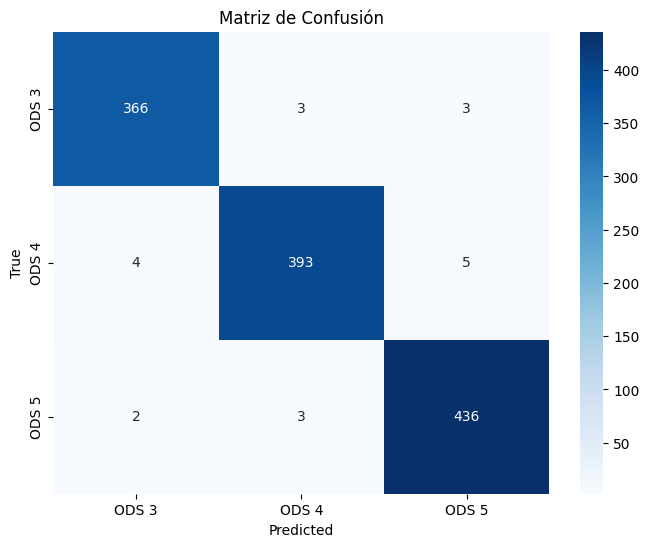

In [42]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["ODS 3", "ODS 4", "ODS 5"], yticklabels=["ODS 3", "ODS 4", "ODS 5"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

### 4.3.9.2.1 Interpretación y análisis de la matriz de confusión

### Elementos importantes de la matriz de confusión:

- **ODS 3**:
   - **366** predicciones correctas: El modelo clasificó correctamente **366** instancias de ODS 3.
   - **3** errores como ODS 4.
   - **3** errores como ODS 5.
   
- **ODS 4**:
   - **393** predicciones correctas: El modelo clasificó correctamente **393** instancias de ODS 4.
   - **4** errores como ODS 3.
   - **5** errores como ODS 5.
   
- **ODS 5**:
   - **436** predicciones correctas: El modelo clasificó correctamente **436** instancias de ODS 5.
   - **2** errores como ODS 3.
   - **3** errores como ODS 4.

### Análisis de resultados:

1. **Altas tasas de precisión en general**: El modelo tiene un buen desempeño en la clasificación de las tres categorías de ODS. Esto se refleja en los altos valores diagonales de la matriz, lo que indica que las predicciones correctas (donde la clase verdadera y la predicha coinciden) son bastante frecuentes.
   
2. **Errores menores en predicciones cruzadas**: Los valores fuera de la diagonal son relativamente pequeños. Por ejemplo, solo **3 instancias de ODS 3** fueron clasificadas incorrectamente como ODS 5 y viceversa. Esto sugiere que el modelo tiene un bajo número de errores de clasificación.

3. **Menor confusión entre ODS 4 y los otros objetivos**: Las predicciones de **ODS 4** tienen una pequeña cantidad de errores hacia **ODS 3** y **ODS 5**, lo cual es una señal de que el modelo no confunde fácilmente este objetivo con los otros.

### **Interpretación general:**

El modelo de clasificación ha logrado identificar correctamente la mayoría de las instancias de **ODS 3 (Salud y Bienestar)**, **ODS 4 (Educación de Calidad)**, y **ODS 5 (Igualdad de Género)**. El bajo número de errores sugiere que el modelo ha capturado bien las características diferenciales de cada clase.




### 4.3.9.3  Análisis de palabras y estrategias para la organización

In [43]:
best_pipeline = grid_search.best_estimator_

# Obtener el vectorizador ajustado del mejor pipeline
vectorizer = best_pipeline.named_steps['tfidf']

# Obtener los nombres de las características (palabras)
feature_names = vectorizer.get_feature_names_out()

# Obtener las puntuaciones TF-IDF (IDF)
tfidf_scores = np.asarray(vectorizer.idf_)

df_palabras_importantes = pd.DataFrame({
    'Palabra': feature_names,
    'Puntaje_IDF': tfidf_scores
})

# Ordenar el DataFrame por los puntajes de importancia (IDF) de mayor a menor
df_palabras_importantes = df_palabras_importantes.sort_values(by='Puntaje_IDF', ascending=False)

# Mostrar las primeras 10 palabras más influyentes
palabras_impor= pd.DataFrame(df_palabras_importantes.head(50))
print(palabras_impor)

                Palabra  Puntaje_IDF
2962             lisboa     8.256650
2728     inmovilización     8.256650
397            ampollas     8.256650
3665              plomo     8.256650
2241              flynn     8.256650
4021      racionamiento     7.851185
2517           hovgaard     7.851185
1887             esalud     7.851185
3706         portafolio     7.851185
165                  a3     7.851185
2197              feroe     7.851185
2166       familiaridad     7.851185
3369            nómadas     7.851185
4505                 sp     7.851185
2150    fachhochschulen     7.851185
2843              islam     7.851185
4023              radio     7.851185
2380            georgia     7.851185
2848          islámicos     7.851185
1029  condicionalidades     7.851185
2679          inflación     7.851185
2384                ges     7.851185
1643           diálisis     7.851185
4468      socialización     7.851185
2640         incubadora     7.851185
438                apex     7.851185
2

### - **Análisis de las palabras identificadas**:
Las palabras que aparecen en la lista tienen puntajes **IDF (Inverse Document Frequency)**, que reflejan la relevancia de cada palabra en el conjunto de datos. A mayor puntaje IDF, más relevante es la palabra dentro de su contexto, ya que es menos común en todos los documentos.
  
Estas palabras tienen un alto puntaje de **IDF**, lo que significa que son poco frecuentes en el conjunto de datos general, pero son altamente relevantes en los documentos donde aparecen. Se pueden hacer ciertas conexiones con los **ODS** en función de las palabras identificadas:

- **ODS 3 (Salud y Bienestar)**: Palabras como "salud", "plomo", "incubadora", y "soins" están relacionadas con temas de salud, atención médica y bienestar. Estas palabras reflejan preocupaciones de los ciudadanos en relación con la calidad de la atención médica, contaminación (plomo) y servicios médicos en general.
  
- **ODS 4 (Educación de Calidad)**: Palabras como "fachhochschulen", "condicionalidades", "estímulo", "portafolio", y "socialización" se asocian con temas de educación y formación académica. Estas palabras indican preocupación por la calidad educativa, accesibilidad y el enfoque en la educación técnica y superior.
  
- **ODS 5 (Igualdad de Género)**: Palabras como "migración", "nómadas", "islam", y "aspirar" pueden asociarse con temas de inclusión social, igualdad de oportunidades y derechos de las mujeres, especialmente en contextos de migración y culturas diversas.

### - **Posibles Estrategias para la Organización**:
Con base en los resultados obtenidos por el modelo, se pueden plantear estrategias que la organización puede implementar para abordar los temas más relevantes y obtener el mayor impacto en relación con los **ODS**.

#### Estrategia 1: **Enfoque en Salud Pública (ODS 3)**
- **Descripción**: La aparición de términos relacionados con "salud", "plomo", y "incubadora" destaca problemas en torno a la atención médica y la contaminación. La organización puede priorizar políticas y programas que mejoren la infraestructura de salud, con un enfoque particular en reducir los riesgos por exposición a contaminantes (como el plomo) y mejorar los servicios de salud infantil.
- **Justificación**: Estas palabras sugieren que hay preocupaciones en la comunidad sobre la salud pública, lo que puede estar relacionado con la infraestructura hospitalaria o la prevención de enfermedades relacionadas con la contaminación. Atender estas preocupaciones puede mejorar la percepción pública y aumentar la confianza en las políticas de salud.

#### Estrategia 2: **Mejora de la Educación Técnica y Vocacional (ODS 4)**
- **Descripción**: La relevancia de palabras como "fachhochschulen", "condicionalidades", y "portafolio" muestra una demanda por mejorar el acceso a la educación técnica y superior. La organización puede invertir en programas educativos que mejoren las oportunidades de formación técnica, especialmente para jóvenes en regiones desfavorecidas.
- **Justificación**: Las palabras indican que existen preocupaciones por la calidad y la equidad en la educación. La organización puede colaborar con instituciones educativas para proporcionar más recursos, becas y programas de inclusión que fomenten la educación técnica y vocacional de calidad.

#### Estrategia 3: **Políticas de Inclusión Social y Migración (ODS 5)**
- **Descripción**: Palabras como "migración", "nómadas", e "islam" reflejan un enfoque en la integración social y cultural. La organización puede diseñar políticas para facilitar la inclusión de comunidades migrantes y mujeres en riesgo, promoviendo programas de integración, asistencia y protección.
- **Justificación**: Estas palabras revelan preocupaciones sobre la integración y los derechos de los migrantes y mujeres, que a menudo enfrentan barreras para la inclusión social. Crear políticas que promuevan la igualdad de género y la inclusión de poblaciones migrantes es crucial para garantizar la cohesión social.

### - **Utilidad de la información para la organización**:
- **Acción basada en datos concretos**: La organización puede utilizar estas palabras clave y sus contextos asociados para diseñar políticas más específicas y dirigidas. En lugar de basar sus decisiones en datos anecdóticos o suposiciones, ahora puede tomar medidas concretas enfocadas en las preocupaciones reales de los ciudadanos.
  
- **Optimización de recursos**: La identificación de las palabras más relevantes permite a la organización focalizar recursos (humanos, financieros, etc.) en las áreas donde se necesitan con mayor urgencia. Esto garantiza una mayor efectividad en las intervenciones sociales.
  
- **Incremento del impacto social**: Al basarse en los resultados del análisis del modelo, la organización puede diseñar estrategias que realmente atiendan las necesidades de la población, lo que aumentará el impacto de sus programas y mejorará la percepción pública.


## **4.4 Justificación de la elección del modelo SVM.**

El SVM (Support Vector Machines) fue seleccionado como el modelo final para este proyecto debido a su rendimiento superior en la clasificación de opiniones ciudadanas y su capacidad para asociarlas con los Objetivos de Desarrollo Sostenible (ODS) 3, 4 y 5. Tras comparar tres modelos diferentes – SVM, XGBoost y Naive Bayes – el SVM se destacó con el mejor F1 score, logrando un valor de 0.98, frente a 0.95 de XGBoost y 0.976 de Naive Bayes.

Resultados y razones para su elección:
* F1 score más alto (0.98): El F1 score es una métrica clave en este tipo de proyectos, ya que pondera de manera equilibrada la precisión y el recall, siendo especialmente útil cuando se busca evitar tanto falsos positivos como falsos negativos. El SVM presentó el mejor equilibrio entre ambas métricas, lo que lo convierte en la mejor opción para clasificar con precisión las opiniones textuales.

* Capacidad para manejar datos textuales complejos: En el contexto del análisis de texto, donde los datos tienden a tener una alta dimensionalidad debido al gran número de palabras únicas (características), el SVM es particularmente eficaz. La forma en que maximiza los márgenes entre las clases en un espacio de alta dimensionalidad permitió que el modelo lograra una mejor separación entre las opiniones asociadas a los diferentes ODS, reduciendo los errores de clasificación.

* Manejo de clases bien definidas: Los ODS (3, 4 y 5) representan categorías claras y distintas, lo que hace que la separación entre clases sea más precisa. El SVM se desempeña excepcionalmente bien en estos escenarios, ya que optimiza un hiperplano de decisión que maximiza el margen entre las clases, asegurando que las opiniones ciudadanas se clasifiquen correctamente.

* Comparación con otros modelos: Aunque XGBoost es un modelo robusto, su F1 score de 0.95 indicó que no alcanzó el mismo nivel de precisión que el SVM. Por otro lado, Naive Bayes logró un F1 score de 0.976, lo que es bastante bueno, pero suposiciones simplificadas sobre la independencia entre características lo hicieron menos adecuado para capturar las interrelaciones complejas entre palabras en los textos.

* las matrices de confusión también refuerzan el rendimiento superior del SVM. En la matriz de confusión de SVM, se observa que tiene los valores más altos en la diagonal principal, lo que indica un alto número de clasificaciones correctas. Por ejemplo, en la clase correspondiente al ODS 5, el SVM correctamente clasificó 436 instancias, mientras que Naive Bayes y XGBoost tuvieron un menor número de clasificaciones correctas en varias clases.
Estas cifras reflejan la capacidad del SVM para capturar mejor las relaciones complejas entre las opiniones de los ciudadanos y los ODS, logrando minimizar tanto los falsos positivos como los falsos negativos. La precisión general del SVM en la clasificación de las opiniones queda reflejada en su matriz de confusión, donde se puede apreciar una menor cantidad de errores comparado con los otros modelos.

##**4.5 Aporte de los resultados obtenidos alineados a los objetivos planteados**

###**Objetivo 1.**
 Crear un modelo automatizado de análisis de textos capaz de procesar grandes cantidades de opiniones y clasificarlas de manera precisa en relación con los ODS 3, 4 y 5

###Aporte del modelo SVM:

El modelo SVM ha mostrado una exactitud del 98.35%, lo que indica que puede clasificar con un alto nivel de precisión las opiniones ciudadanas dentro de las tres categorías (ODS 3, 4 y 5).
Esto cumple con creces el objetivo de tener un modelo capaz de procesar datos masivos de manera automatizada, reduciendo la necesidad de una intervención manual intensiva.
Además, la clasificación precisa ayuda a segmentar claramente los problemas de salud, educación e igualdad de género en los cuales se enfocan los ODS, permitiendo un análisis eficiente y enfocado.
###**Objetivo 2.**
Mejorar la eficiencia en el uso de recursos, al reducir la intervención manual en el análisis de datos, permitiendo que el UNFPA destine más recursos a la ejecución de políticas y programas eficaces
### Aporte del modelo SVM:

La capacidad del modelo para automatizar el análisis de grandes volúmenes de texto permite ahorrar recursos en términos de tiempo y personal que de otra manera se dedicarían a analizar manualmente las opiniones ciudadanas.
El alto rendimiento del modelo con métricas como recall y precisión superiores al 98% asegura que la organización pueda confiar en las clasificaciones automáticas para tomar decisiones informadas rápidamente.
Este ahorro en recursos humanos y tiempo puede ser redirigido a la ejecución y mejora de políticas públicas más eficientes.

###**Objetivo 3.**
Generar información valiosa sobre las percepciones y necesidades de la población en cuanto a salud, educación e igualdad de género, para apoyar la toma de decisiones estratégicas y el desarrollo de políticas públicas
###Aporte del modelo SVM:

El modelo SVM no solo clasifica las opiniones con precisión, sino que, al aplicar técnicas como TF-IDF, también permite identificar las palabras más influyentes y los temas clave dentro de las opiniones, proporcionando insights profundos sobre los problemas más relevantes para los ciudadanos.
Esto genera información valiosa que puede ser usada para formular políticas públicas precisas dirigidas a las áreas más necesitadas, como la atención médica, acceso a la educación o políticas de igualdad de género.
Con estas predicciones, los responsables de políticas pueden identificar áreas críticas que requieren atención inmediata, lo que permite una toma de decisiones más rápida y precisa.
###**Objetivo 4.**
Asegurar la evolución continua del modelo analítico, ajustándolo a nuevos datos y tendencias para mantener la precisión y relevancia de los resultados
###Aporte del modelo SVM:

Los resultados obtenidos con métricas de rendimiento muy altas muestran que el modelo es confiable, pero también adaptable. El modelo SVM es flexible y puede ser reentrenado fácilmente conforme se recolecten más opiniones y datos nuevos.
Dado que se espera que el modelo maneje datos cambiantes y diversas opiniones, la capacidad del modelo para mantener altos niveles de precisión tras el reentrenamiento asegura que la calidad del análisis no se degrade con el tiempo.
Esto ayuda a cumplir el objetivo de mantener el modelo actualizado y relevante conforme evolucionan las opiniones ciudadanas.

###**Objetivo 5.**
Facilitar la transmisión de resultados a los distintos stakeholders, asegurando que los insights obtenidos sean claros y útiles para la toma de decisiones
###Aporte del modelo SVM:

El modelo SVM permite no solo clasificar, sino también generar reportes y métricas claras que pueden ser fácilmente interpretadas por los stakeholders.
Con la matriz de confusión y métricas como la puntuación F1, precisión y recall, los resultados del modelo pueden ser fácilmente explicados y presentados a los stakeholders, quienes pueden utilizar esta información para mejorar la toma de decisiones estratégicas.
Además, la identificación de las palabras clave más influyentes proporciona a los líderes y tomadores de decisiones una visión clara de los temas que realmente preocupan a los ciudadanos, lo que mejora la comunicación y alineación entre diferentes áreas de la organización.

# 5    Entrega de los datos de prueba categorizados

## 5.1 Carga de datos

In [44]:
# Intentar leer el archivo Excel con diferentes motores
file_path = "/content/sample_data/PROYECTO1/TestODScat_345.xlsx"

try:
    df_ODS_test = pd.read_excel(file_path, engine='openpyxl')
except:
    df_ODS_test = pd.read_excel(file_path, engine='xlrd')  # Usar xlrd si openpyxl falla

# Crear una copia del dataframe
data_test = df_ODS_test.copy()

# Si hay problemas con tildes, reemplazarlos manualmente
def replace_special_chars(df):
    # Definir un diccionario de reemplazo
    replacements = {
        'Ã¡': 'á', 'Ã©': 'é', 'Ã­': 'í', 'Ã³': 'ó', 'Ãº': 'ú',
        'Ã': 'Á', 'Ã': 'É', 'Ã': 'Í', 'Ã': 'Ó', 'Ã': 'Ú',
        'Ã±': 'ñ', 'Ã': 'Ñ', 'Ã¼': 'ü', 'Ã': 'Ü', 'ã³':'í',
        'ã©':'é', 'ã¡':'á', 'ãº':'ú', 'ã°':'ó', 'ã':'ñ', 'ã':'ü'
    }
    # Reemplazar caracteres en cada columna de tipo objeto
    for col in df.select_dtypes(include=['object']).columns:
        for old, new in replacements.items():
            df[col] = df[col].str.replace(old, new)
    return df

# Reemplazar caracteres especiales
data_test = replace_special_chars(data_test)
data_test.head(10)

,Textos_espanol,sdg
0,Han examinado la contribución de las universi...,NaN
1,"En la última década, y en particular desde 201...",NaN
2,¿En qué países los estudiantes de alto rendimi...,NaN
3,A raíz de su preocupación por el hecho de que ...,NaN
4,"1999|H5|, Ares Abalde, 2014[ij]. El pequeño nú...",NaN
5,"A continuación, se propone una síntesis de paí...",NaN
6,"A diferencia de los acuerdos anteriores, la nu...",NaN
7,"Por ejemplo, los servicios de urgencias tienen...",NaN
8,A lo largo de diez años cerraron escuelas espe...,NaN
9,A medida que se implemente la nueva estructura...,NaN


## 5.2 Aplicación del modelo seleccionado

In [45]:
X_test_unlabeled = data_test['Textos_espanol']

# Predecir las etiquetas utilizando el modelo entrenado
predicciones = grid_search.best_estimator_.predict(X_test_unlabeled)


## 5.3 Agregar las predicciones como columna adicional

In [46]:
data_test['sdg'] = predicciones
data_test.head(10)


,Textos_espanol,sdg
0,Han examinado la contribución de las universi...,4
1,"En la última década, y en particular desde 201...",3
2,¿En qué países los estudiantes de alto rendimi...,4
3,A raíz de su preocupación por el hecho de que ...,3
4,"1999|H5|, Ares Abalde, 2014[ij]. El pequeño nú...",4
5,"A continuación, se propone una síntesis de paí...",4
6,"A diferencia de los acuerdos anteriores, la nu...",4
7,"Por ejemplo, los servicios de urgencias tienen...",3
8,A lo largo de diez años cerraron escuelas espe...,4
9,A medida que se implemente la nueva estructura...,4


## 5.4 Archivo actualizado con las etiquetas asignadas

In [47]:
# Guardar el archivo actualizado con las etiquetas asignadas
output_file_path = '/content/sample_data/PROYECTO1/particion_prueba_estudiantes.xlsx'  # Reemplaza con la ruta de salida
data_test.to_excel(output_file_path, index=False)

print(f"Archivo guardado en: {output_file_path}")


Archivo guardado en: /content/sample_data/PROYECTO1/particion_prueba_estudiantes.xlsx


#Mapa de actores relacionado con el producto de datos creado

Se encuentra en el documento adjunto (PDF) que se encuentra en el repositorio

# Trabajo en equipo

Se encuentra en el documento adjunto (PDF) que se encuentra en el repositorio